In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim

## Define Dataset Class for Synthetic data and create an object

The following code defines a Dataset class for the synthetic data and create an object of this class. The data points are sampled from multiple Gaussian distributions with specified means and standard deviations.

In [4]:
class ToyDataset(Dataset):
    """Dataset class to be used in PyTorch"""

    def __init__(self):
        
        np.random.seed(42) # set seed for reproducibility
        
        n_samples = 500

        # 1D example
        # true_means = np.array([[-5], [0], [5]]) # (K, D) - mean of each gaussian at each dimension
        # true_stds = np.array([[0.8], [1.0], [0.5]]) # (K, D) - std of each gaussian at each dimension
        # true_weights = np.array([0.3, 0.4, 0.3]) # (K,) - weight of each gaussian

        # 2D example
        self.true_means = np.array([[-5, -2], [0, 2], [5, 5]]) # (K, D) - mean of each gaussian at each dimension
        self.true_stds = np.array([[0.8, 0.3], [1.0, 0.3], [0.5, 1.0]]) # (K, D) - std of each gaussian at each dimension
        self.true_weights = np.array([0.3, 0.4, 0.3]) # (K,) - weight of each gaussian

        self.true_variances = self.true_stds**2

        print(f"Shape of true_means = {self.true_means.shape}")
        print(f"Shape of true_variances = {self.true_variances.shape}")
        print(f"Shape of true_weights = {self.true_weights.shape}")

        self.K = self.true_means.shape[0] # number of components
        self.D = self.true_means.shape[1] # dimension

        # Create synthetic dataset
        self.data = np.concatenate([
            np.random.normal(loc=mean, scale=std, size=(int(weight * n_samples), self.D)) 
            for mean, std, weight in zip(self.true_means, self.true_stds, self.true_weights)
        ], axis=0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        
        return sample
    
# Create the ToyDataset class object
data = ToyDataset()

Shape of true_means = (3, 2)
Shape of true_variances = (3, 2)
Shape of true_weights = (3,)


## Plot True pdf

Plot the true pdf that the data is generated at each dimension

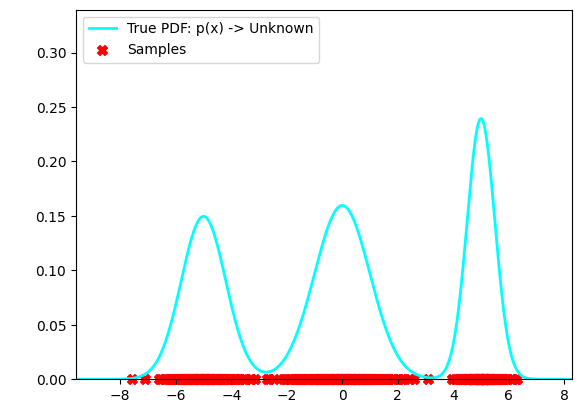

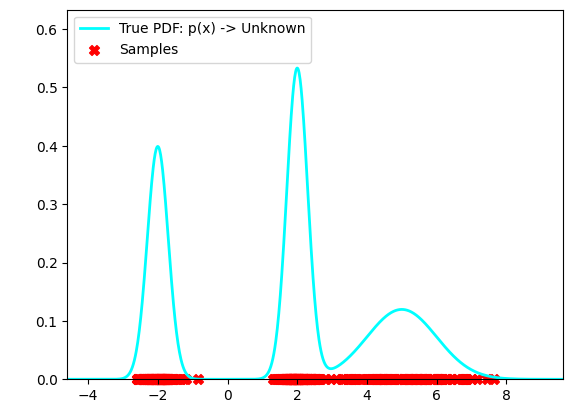

In [5]:
true_variances = data.true_variances
true_means = data.true_means
true_weights = data.true_weights

# Plot True pdf at each dimension
for d in range(data.D):
    x_values = np.linspace(min(data[:, d]) - 2, max(data[:, d]) + 2, 1000)

    density = np.zeros_like(x_values)
    for k in range(data.K):
        pdf = (1 / np.sqrt(2 * np.pi * true_variances[k, d])) * np.exp(-0.5 * ((x_values - true_means[k, d])**2) / true_variances[k, d])
        density += (true_weights[k] * pdf)
    plt.plot(x_values, density, color='cyan', linewidth=2, label='True PDF: p(x) -> Unknown')

    # Plot samples from the pdf
    plt.scatter(data[:, d], np.zeros_like(data[:, d]), c='red', marker='X', s=50, label='Samples', clip_on=False)

    plt.ylabel('Probability Density', color='white', fontsize=16)
    plt.legend(loc='upper left')
    plt.grid(False)
    plt.xlim(min(data[:, d]) - 2, max(data[:, d]) + 2)
    plt.ylim(0.0, max(density) + 0.1)
    plt.show()

## Create Mixture of Gaussian (MoG) class to be used with gradient-based optimization

The following code generates MoG class to esimate the parameters of the model using EM-based optimization

In [6]:
class MoG(nn.Module): # The class should be inherited from nn.Module to utilize PyTorch in gradient-based optimization
    def __init__(self, K, D):
        super(MoG, self).__init__() # call the __init__ function of nn.Module
        """
        Initialize Mixture of Gaussians with EM optimization
        
        Args:
            K (int): Number of Gaussian components (K)
            D (int): Dimensionality of the input data (D)
        """
        self.K = K
        self.D = D
        
        np.random.seed(42) # set seed for reproducibility
        
        # Initialize weights (mixing coefficients) (we'll use softmax to ensure they sum to 1)
        self.weight_logits = nn.Parameter(torch.zeros(self.K))

        # Initialize means
        self.means = nn.Parameter(torch.randn(self.K, self.D) * 2)
        
        # Initialize log variances (we use log to ensure positivity)
        self.log_vars = nn.Parameter(torch.zeros(self.K, self.D))        

        self.PI = torch.tensor(np.pi, dtype=torch.float32)
    
    @property
    def variances(self):
        return torch.exp(self.log_vars)
    
    @property
    def mixture_weights(self):
        return torch.softmax(self.weight_logits, dim=0)
    
    def _log_multivariate_normal_pdf(self, X, mean, var):
        """
        Compute PDF of multivariate normal distribution for a given data matrix X and the parameters of the distribution.
        Note that this implementation assumes diagonal covariance matrix.
        Args:
            X (torch.Tensor): Input data of shape (N, D)
            mean (torch.Tensor): Mean of each dimension (D,).
            var (torch.Tensor): Variance of each dimension (D,).
        
        Return:
            prob (torch.Tensor)): Probabilities for each data point (N,).
        """
        diff = X - mean
        log_det = torch.sum(torch.log(var))
        quad = torch.sum(diff * diff / var, axis=1)

        prob = -0.5 * (self.D * torch.log(2 * self.PI) + log_det + quad)

        return prob
   
    def log_likelihood(self, X):
        """
        Compute log likelihood of the data
        Args:
            X (torch.Tensor): Input data of shape (N, D)
            
        Return:
            ll (torch.Tensor): log likelihood of shape []
        """
        N = X.shape[0]
        log_probs = torch.zeros(self.K, N)
        
        for k in range(self.K):
            log_probs[k] = self._log_multivariate_normal_pdf(X, self.means[k], self.variances[k])

        log_probs = log_probs + torch.log(self.mixture_weights.unsqueeze(1))

        log_likelihood = torch.logsumexp(log_probs, dim=0)

        ll = log_likelihood.sum()
        
        return ll

    # In PyTorch, we need to have a forward function to use gradient-based optimizer.
    def forward(self, X):
        """
        Forward function that evaluates the model and compute the NLL loss.
        Args:
            X (torch.Tensor): Input data of shape (N, D)

        Return:
            NLL_loss (torch.Tensor): Negative log-likelihood loss of shape []
        """
        # define loss function: negative log-likelihood
        NLL_loss = -self.log_likelihood(X)
        
        return NLL_loss

    def sample(self, n_samples):
        """
        Generate samples from the mixture model
        Args:
            n_samples (int): number of samples to be generated
        
        Return:
            samples (torch.Tensor): Generated samples of shape (n_samples, D)
        """
        # Sample component indices
        indices = torch.multinomial(self.mixture_weights, n_samples, replacement=True).squeeze()
        
        # Generate samples from each selected component
        samples = torch.empty((n_samples, self.D))
        for i, k in enumerate(indices):
            samples[i] = self.means[k] + torch.exp(0.5 * self.log_vars[k]) * torch.randn(self.D)
            
        return samples
    


## Training function

In [7]:
def train(model, dataset, n_epochs=2000, batch_size=500, learning_rate=1e-1):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    losses = []
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        n_batches = 0
        
        for batch in dataloader:
            # Convert numpy array to torch tensor if necessary
            if not isinstance(batch, torch.Tensor):
                batch = torch.tensor(batch, dtype=torch.float32)
            
            optimizer.zero_grad()
            loss = model(batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}')
    
    return losses

## Start training

Epoch [100/2000], Loss: 2028.8030
Epoch [200/2000], Loss: 2027.5134
Epoch [300/2000], Loss: 1621.4435
Epoch [400/2000], Loss: 1379.1804
Epoch [500/2000], Loss: 1379.1300
Epoch [600/2000], Loss: 1379.1299
Epoch [700/2000], Loss: 1379.1299
Epoch [800/2000], Loss: 1379.1299
Epoch [900/2000], Loss: 1379.1299
Epoch [1000/2000], Loss: 1379.1299
Epoch [1100/2000], Loss: 1379.1299
Epoch [1200/2000], Loss: 1379.1299
Epoch [1300/2000], Loss: 1379.1299
Epoch [1400/2000], Loss: 1379.1300
Epoch [1500/2000], Loss: 1379.1300
Epoch [1600/2000], Loss: 1379.1300
Epoch [1700/2000], Loss: 1379.1414
Epoch [1800/2000], Loss: 1379.1299
Epoch [1900/2000], Loss: 1379.1299
Epoch [2000/2000], Loss: 1379.1299
Learned means: tensor([[-3.5303e-03,  1.9950e+00],
        [ 5.0254e+00,  5.1161e+00],
        [-5.0272e+00, -1.9931e+00]])
Learned variances: tensor([[1.0488, 0.0808],
        [0.1945, 1.0675],
        [0.5959, 0.0898]])
Learned mixture weights: tensor([0.3999, 0.3000, 0.3001])


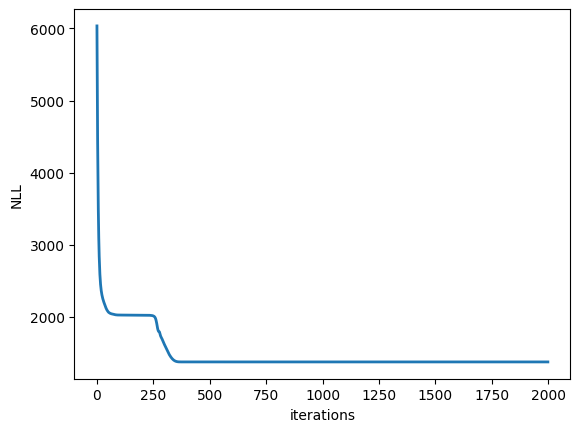

In [8]:
K = 3
model = MoG(K=K, D=data.D)
losses = train(model, data)

# After training, you can access the learned parameters:
print("Learned means:", model.means.data)
print("Learned variances:", model.variances.data)
print("Learned mixture weights:", model.mixture_weights.data)

plt.plot(range(len(losses)), losses, linewidth=2)
plt.ylabel('NLL')
plt.xlabel('iterations')
plt.show()

## Plot True pdf and the Predicted pdf

Plot the true pdf that the data is generated at each dimension and the pdf predicted by MoG

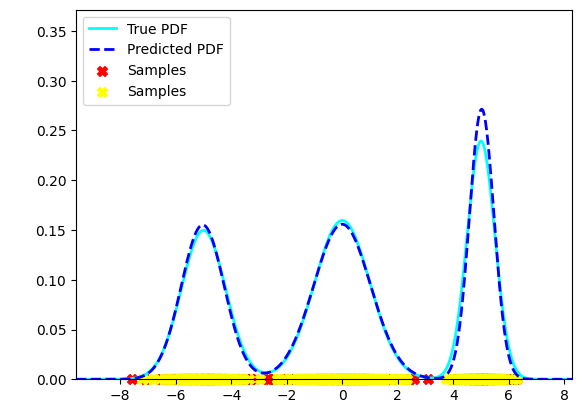

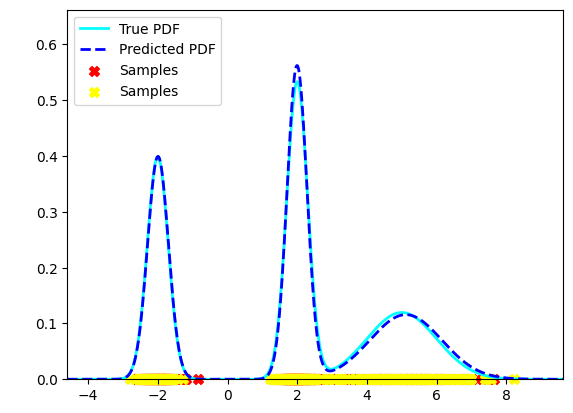

In [9]:
for d in range(data.D):
    x_values = np.linspace(min(data[:, d]) - 2, max(data[:, d]) + 2, 1000)

    # Plot true density
    density = np.zeros_like(x_values)
    for k in range(data.K):
        pdf = (1 / np.sqrt(2 * np.pi * true_variances[k, d])) * np.exp(-0.5 * ((x_values - true_means[k, d])**2) / true_variances[k, d])
        density += (true_weights[k] * pdf)
    plt.plot(x_values, density, color='cyan', linewidth=2, label='True PDF')

    # Plot predicted density
    pred_density = np.zeros_like(x_values)
    for k in range(K):
        var = np.exp(model.log_vars[k, d].detach().numpy())
        mean = model.means[k, d].detach().numpy()
        weight = model.mixture_weights[k].detach().numpy()

        pdf = (1 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * ((x_values - mean)**2) / var)
        pred_density += (weight * pdf)
    plt.plot(x_values, pred_density, color='blue', linewidth=2, linestyle='--', label='Predicted PDF')

    # Plot samples generated from true density
    plt.scatter(data[:, d], np.zeros_like(data[:, d]), c='red', marker='X', s=50, label='Samples', clip_on=False)

    # Generate samples from the predicted density and plot
    data_samples = model.sample(500).detach().numpy()
    plt.scatter(data_samples[:, d], np.zeros_like(data_samples[:, d]), c='yellow', marker='X', s=50, label='Samples', clip_on=False)

    plt.ylabel('Probability Density', color='white', fontsize=16)
    plt.legend(loc='upper left')
    plt.grid(False)
    plt.xlim(min(data[:, d]) - 2, max(data[:, d]) + 2)
    plt.ylim(0.0, max(max(density), max(pred_density)) + 0.1)
    plt.show()